# Testing creation of GMM from posterior samples

Here I test out the creation of a two-dimensional Gaussian Mixture model from a set of posterior samples. In this case I will take the $h_0$ and $\cos{\iota}$ samples.

In [23]:
%matplotlib inline

from __future__ import print_function

import os
import sys
sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

# import required modules
import numpy as np
from sklearn import mixture
from scipy import linalg
from scipy import stats

from lalapps import pulsarpputils as pppu

import matplotlib as mpl
from matplotlib import pyplot as pl

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

mpl.rcParams.update(mplparams)

In [68]:
def gmm_prior(prevpostfile, par1, par2, par1lims=[-np.inf, np.inf], par2lims=[-np.inf, np.inf], ncomps=10):
    """
    Create a 2D Gaussian Mixture Model for use as a prior.

    This will use the BayesianGaussianMixture Model from scikit-learn, which fits a Dirichlet Process Gaussian
    Mixture Model to the input data infering the number of components required. The input to this should be
    a previously calculated posterior sample file. The parameters `par1` and `par2` will be extracted from this
    file. The `par1lims` and `par2lims` should be hard upper an lower limints of the particular parameters. If
    any of these are not +/-infinity then the samples will be duplicated and reflected around that limit. This
    is to avoid edge effects for the inferred Gaussian distributions. `ncomps` sets the hyperparameter used in
    the Dirichlet process related to the number of Gaussian components.

    The means, covariance matrices and weights of the Gaussian components will be returned.

    An example of using this would be for "H0" versus "COSIOTA", in which case the limits on "H0" could be
    [0.0, inf] and for "COSIOTA" could be [-1.0, 1.0].
    """

    means = None
    covs = None
    weights = None

    ncompsu = ncomps

    if not os.path.isfile(prevpostfile):
        print("Error... previous posterior sample file '%s' does not exist" % prevpostfile, file=sys.stderr)
        return means, covs
      
    # get samples
    try:
        possamps, B, N = pppu.pulsar_nest_to_posterior(prevpostfile)
        parone = possamps[par1.upper()].samples
        partwo = possamps[par2.upper()].samples
    except:
        print("Error... could not extract '%s' or '%s' from posterior sample file '%s'" % (par1, par2, prevpostfile), file=sys.stderr)
        return means, covs, weights

    # reflect and duplicate samples if required for par1 (for each reflection add to ncomp)
    refsamps1 = []
    refsamps2 = []
    for lim in par1lims:
        if np.isfinite(lim):
            # reflect about this limit
            dist1 = lim - parone
            refsamps1.append(np.copy(parone) + 2.*dist1)
            refsamps2.append(np.copy(partwo))
            ncompsu += ncomps

    # stack samples
    paronenew = np.copy(parone)
    partwonew = np.copy(partwo)
    for i in range(len(refsamps1)):
        paronenew = np.vstack((paronenew, refsamps1[i]))
        partwonew = np.vstack((partwonew, refsamps2[i]))

    # reflect and duplicate samples if required for par2
    refsamps1 = []
    refsamps2 = []
    ncomps = ncompsu
    for lim in par2lims:
        if np.isfinite(lim):
            # reflect about this limit
            dist2 = lim - partwonew
            refsamps1.append(np.copy(paronenew))
            refsamps2.append(np.copy(partwonew) + 2.*dist2)
            ncompsu += ncomps

    # stack samples
    for i in range(len(refsamps1)):
        paronenew = np.vstack((paronenew, refsamps1[i]))
        partwonew = np.vstack((partwonew, refsamps2[i]))

    # scale parameters to avoid dynamic range issues
    paronescale = np.std(paronenew)
    partwoscale = np.std(partwonew)
    scales = np.array([paronescale, partwoscale])
    scalesmat = np.identity(2)*scales

    pars = np.hstack((paronenew/paronescale, partwonew/partwoscale))

    # run DPGMM
    dpgmm = mixture.BayesianGaussianMixture(n_components=ncompsu, covariance_type='full').fit(pars)

    # predict the GMM components in which the original (unreflected) samples live
    #parpred = dpgmm.predict(np.hstack((parone/paronescale, partwo/partwoscale)))
    parpred = dpgmm.predict(pars)
    
    # get the means, covariances and weights of the GMM components in which actually contain predicted samples
    means = []
    covs = []
    weights = []
    print()
    for i, (mean, covar, weight) in enumerate(zip(dpgmm.means_, dpgmm.covariances_, dpgmm.weights_)):
        if np.any(parpred == i): # check if any samples predicted to be in component i
            # check that mode is within 3.5 sigma of limits otherwise don't include it
            outlims = 0
            for (mus, sigs, lowlim, highlim) in zip(mean*scales, scales*np.sqrt(np.diag(covar)), [par1lims[0], par2lims[0]], [par1lims[1], par2lims[1]]):
                if mus < lowlim - 3.5*sigs or mus > highlim + 3.5*sigs:
                    outlims += 1

            if outlims == 2:
                continue

            # rescale to get back to true values
            means.append(mean*scales)
            covs.append(np.dot(scalesmat, np.dot(covar, scalesmat)))
            weights.append(weight)

    if len(means) == 0:
        print("Error... no GMM components returned", file=sys.stderr)
    
    return means, covs, weights

In [69]:
# set previous posterior file
prevpostfile = '/home/matthew/testing/lalapps_knope_O2/posterior_samples_J0534+2200.hdf'

# parameters to extract
par1 = 'h0'
par2 = 'cosiota'

# limits for parameters
par1lims = [0., np.inf]
par2lims = [-1., 1.]

# number of components hyperparameter
ncomp = 4

means, covs, weights = gmm_prior(prevpostfile, par1, par2, par1lims=par1lims, par2lims=par2lims, ncomps=ncomp)

Read columns ['COSIOTA', 'F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'HSCALARL', 'POSEPOCH', 'DIST', 'F7_FIXED', 'PHI21', 'F4_FIXED', 'PSITENSOR', 'HPLUS', 'PHI0VECTOR', 'HCROSS', 'PHI22', 'DEC', 'I21', 'COSTHETA', 'FREQNUM', 'PX', 'F1_FIXED', 'Q22', 'F8_FIXED', 'F2_FIXED', 'F9_FIXED', 'RA', 'F6_FIXED', 'IOTA', 'CGW', 'C22', 'C21', 'df', 'I31', 'HVECTORX', 'F5_FIXED', 'PHI0TENSOR', 'PMDEC', 'HSCALARB', 'THETA', 'PSIVECTOR', 'PEPOCH', 'PMRA', 'F3_FIXED', 'F0_FIXED', 'HVECTORY', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']



In [21]:
# get samples
samples, evsig, evnoise = pppu.pulsar_nest_to_posterior(prevpostfile)

Read columns ['COSIOTA', 'F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'H0', 'PHI0', 'PSI', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'HSCALARL', 'POSEPOCH', 'DIST', 'F7_FIXED', 'PHI21', 'F4_FIXED', 'PSITENSOR', 'HPLUS', 'PHI0VECTOR', 'HCROSS', 'PHI22', 'DEC', 'I21', 'COSTHETA', 'FREQNUM', 'PX', 'F1_FIXED', 'Q22', 'F8_FIXED', 'F2_FIXED', 'F9_FIXED', 'RA', 'F6_FIXED', 'IOTA', 'CGW', 'C22', 'C21', 'df', 'I31', 'HVECTORX', 'F5_FIXED', 'PHI0TENSOR', 'PMDEC', 'HSCALARB', 'THETA', 'PSIVECTOR', 'PEPOCH', 'PMRA', 'F3_FIXED', 'F0_FIXED', 'HVECTORY', 'PHI0SCALAR', 'PSISCALAR', 'LAMBDA']


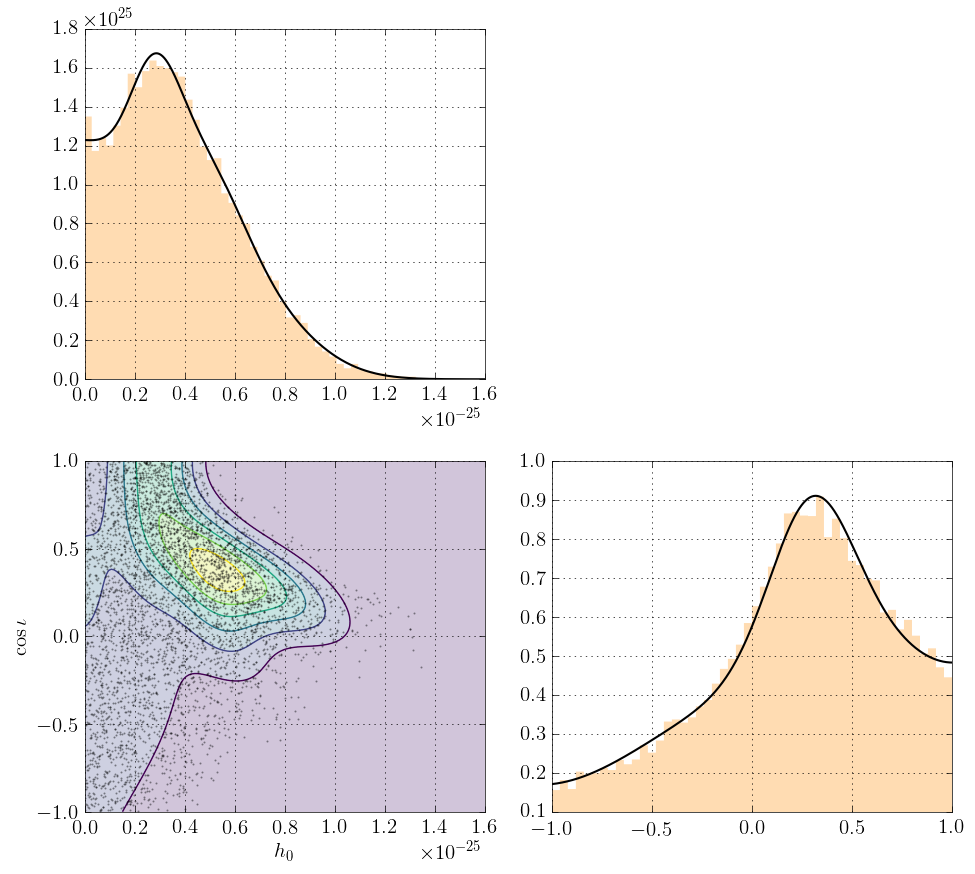

In [173]:
# plot samples and GMM
fig, axs = pl.subplots(2,2, figsize=(10,9))

axs[0][0].hist(samples['H0'].samples, bins=50, normed=True, histtype='stepfilled', alpha=0.3, facecolor='darkorange', edgecolor='none')
axs[1][1].hist(samples['COSIOTA'].samples, bins=50, normed=True, histtype='stepfilled', alpha=0.3, facecolor='darkorange', edgecolor='none')
axs[1][0].plot(samples['H0'].samples[::4], samples['COSIOTA'].samples[::4], '.', alpha=0.3, color='black', markersize=2)
axs[0][1].axis('off')

# overplot expected GMM pdfs
def gmmpdf(x, means, sigmas, weights, pidx):
    gp = np.zeros(len(x))
    for i in range(len(means)):
        mu = means[i][pidx]
        sig = sigmas[i][pidx]
        weight = weights[i]
        rv = stats.norm(loc=mu, scale=sig) # create mode
        gp += weight*rv.pdf(x) # weight each mode

    # re-normalise
    return gp/np.trapz(gp, x)

# get standard deviations for each mode
sigmas = []
for cov in covs:
    sigmas.append(np.sqrt(np.diag(cov)))

h0lims = axs[0][0].get_xlim()
h0s = np.linspace(h0lims[0], h0lims[1], 1000)
pdfh0 = gmmpdf(h0s, means, sigmas, weights, 0)
axs[0][0].plot(h0s, pdfh0, 'k', lw=1.5)

cis = np.linspace(-1., 1., 1000)
pdfh0 = gmmpdf(cis, means, sigmas, weights, 1)
axs[1][1].plot(cis, pdfh0, 'k', lw=1.5)

# create determinants of covariance matrices and inverses of correlation matrices
logdets = []
invcor = []
for i in range(len(covs)):
    invsigmamat = np.identity(2)/sigmas[i]
    invcor.append(np.linalg.inv(np.dot(invsigmamat, np.dot(covs[i], invsigmamat))))
    logdets.append(np.log(np.linalg.det(covs[i])))

# create grid image of Gaussians
imgrid = np.ones((150,150))*-np.inf
h0grid = np.linspace(h0lims[0], h0lims[1], 150)
cigrid = np.linspace(-1., 1., 150)

for i in range(len(h0grid)):
    for j in range(len(cigrid)):
        for k in range(len(covs)):
            vals = (np.array([h0grid[i],cigrid[j]])-means[k])/sigmas[k]
            tmplike = -0.5*(np.dot(vals, np.dot(invcor[k], vals)))
            tmplike += np.log(weights[k])
            tmplike -= (0.5*2.*(np.log(np.pi) + np.log(2.)) + logdets[k])
            imgrid[i,j] = np.logaddexp(imgrid[i,j], tmplike)

imgrid = np.exp(imgrid-np.amax(imgrid))
 
# show 2D image of GMM
axs[1][0].contour(imgrid.T, extent=[h0lims[0], h0lims[1], -1., 1.], cmap='viridis', lw=2)
axs[1][0].contourf(imgrid.T, extent=[h0lims[0], h0lims[1], -1., 1.], cmap='viridis', alpha=0.25)

axs[0][0].set_xlim(h0lims)
axs[1][0].set_xlim(h0lims)
axs[1][0].set_xlabel('$h_0$')
axs[1][0].set_ylim([-1., 1.])
axs[1][0].set_ylabel('$\cos{\iota}$')
axs[1][1].set_xlim([-1., 1.])
pl.tight_layout()